In [61]:

# Given a list of points representing the vertices
points = [[ 1.98040992,  0.66953732,  1.2808793 ],
       [ 0.66953732,  1.98040992, -1.2808793 ],
       [-0.66953732, -1.98040992, -1.2808793 ],
       [-1.98040992,  0.66953732, -1.2808793 ],
       [ 1.98040992, -0.66953732, -1.2808793 ],
       [-0.66953732,  1.98040992,  1.2808793 ],
       [ 0.66953732, -1.98040992,  1.2808793 ],
       [-1.98040992, -0.66953732,  1.2808793 ]]

points_tetrahedron = [[0.66953732, 1.98040992, 3.6876207 ], [1.2743144, 3.9482856, 1.7658049], [-0.66953732,  1.98040992,  1.2808793 ], [-1.2743144,  3.9482856,  3.2026951]]

points_octa = [[4.553062680000001, 3.24219008, 1.2808793], [1.9804099199999998, 0.66953732, 1.2808793], [1.2743144000000002, 3.9482856000000006, 1.7658048999999996], [0.66953732, 1.9804099199999998, -1.2808793], [3.24219008, 4.553062680000001, -1.2808793], [3.9482856000000006, 1.2743144000000002, -1.7658048999999996]]

points_18_v_pentagonal_prism = [[1.4883631600000002, 0.0, 1.4883631600000002], [1.4883631600000002, 1.4883631600000002, 0.0], [0.0, 1.4883631600000002, 1.4883631600000002], [2.00382078, 0.0, 0.0], [-2.003820779999999, 0.0, 0.0], [0.0, 2.00382078, 0.0], [0.0, -2.003820779999999, 0.0], [0.0, 0.0, 2.00382078], [0.0, 0.0, -2.003820779999999], [0.0, -1.48836316, -1.48836316], [1.4883631600000002, 0.0, -1.48836316], [1.4883631600000002, -1.48836316, 0.0], [0.0, 1.4883631600000002, -1.48836316], [-1.48836316, 0.0, -1.48836316], [-1.48836316, 1.4883631600000002, 0.0], [0.0, -1.48836316, 1.4883631600000002], [-1.48836316, 0.0, 1.4883631600000002], [-1.48836316, -1.48836316, 0.0]]

Рёбра многогранника: [(0, 1), (2, 4), (0, 4), (2, 7), (1, 5), (3, 7), (4, 6), (1, 4), (0, 6), (2, 3), (6, 7), (5, 7), (2, 6), (0, 5), (1, 3), (3, 5)]


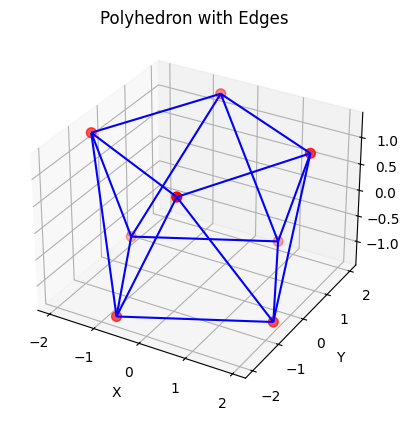

In [63]:
import numpy as np
from scipy.spatial import ConvexHull
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def get_polyhedron_edges(points, tol=1e-6):
    points = np.asarray(points)
    hull = ConvexHull(points)
    simplices = hull.simplices  # Индексы вершин треугольников оболочки
    
    # Функция для нормализации вектора и фиксации ориентации
    def normalize_vector(v):
        norm = np.linalg.norm(v)
        if norm == 0:
            return v
        v = v / norm
        # Фиксируем направление нормали
        if v[0] < 0 or (v[0] == 0 and v[1] < 0) or (v[0] == 0 and v[1] == 0 and v[2] < 0):
            v = -v
        return v
    
    # Шаг 2: Вычисляем нормали и смещения для плоскостей треугольников
    plane_dict = {}
    for i, simplex in enumerate(simplices):
        A, B, C = points[simplex]
        # Векторы ребер
        AB = B - A
        AC = C - A
        # Нормаль к плоскости
        N = np.cross(AB, AC)
        N = normalize_vector(N)
        # Смещение плоскости
        D = -np.dot(N, A)
        # Округляем для учёта погрешностей
        N_rounded = tuple(np.round(N / tol) * tol)
        D_rounded = np.round(D / tol) * tol
        # Ключ для идентификации плоскости
        plane_key = N_rounded + (D_rounded,)
        # Группируем треугольники по плоскостям
        if plane_key not in plane_dict:
            plane_dict[plane_key] = []
        plane_dict[plane_key].append(simplex)
    
    # Шаг 4: Находим внешние рёбра для каждой грани
    edge_set = set()
    for simplices_in_plane in plane_dict.values():
        edges_in_face = []
        for simplex in simplices_in_plane:
            # Рёбра треугольника
            edges = [
                tuple(sorted([simplex[0], simplex[1]])),
                tuple(sorted([simplex[1], simplex[2]])),
                tuple(sorted([simplex[2], simplex[0]]))
            ]
            edges_in_face.extend(edges)
        # Подсчитываем количество каждого ребра в грани
        edge_counts = Counter(edges_in_face)
        # Рёбра, встречающиеся один раз, являются внешними для данной грани
        boundary_edges = [edge for edge, count in edge_counts.items() if count == 1]
        edge_set.update(boundary_edges)
    
    # Финальный список рёбер многогранника
    polyhedron_edges = list(edge_set)
    return polyhedron_edges

def plot_polyhedron(points, edges):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    # Отображаем точки
    points = np.array(points)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="red", s=50)
    
    # Отображаем рёбра
    edge_points = [[points[edge[0]], points[edge[1]]] for edge in edges]
    edge_lines = Line3DCollection(edge_points, colors="blue", linewidths=1.5)
    ax.add_collection3d(edge_lines)
    
    # Настройка отображения
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Polyhedron with Edges")
    plt.show()


edges = get_polyhedron_edges(points)
print("Рёбра многогранника:", edges)

# Визуализация
plot_polyhedron(points, edges)


In [60]:
len(edges)

12

Грани многогранника:
[2, 7, 3]
[1, 4, 0]
[6, 7, 2]
[4, 6, 2]
[4, 6, 0]
[1, 5, 0]
[1, 5, 3]
[5, 7, 3]
[1, 4, 2, 3]
[6, 7, 5, 0]


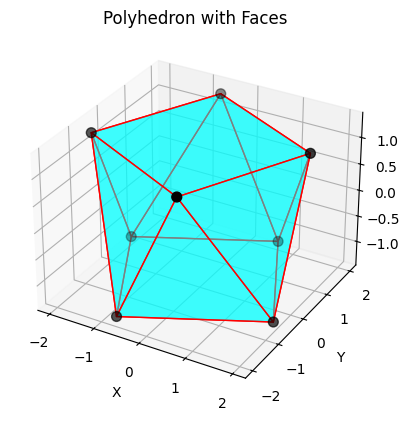

In [62]:
import numpy as np
from scipy.spatial import ConvexHull
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def get_polyhedron_faces(points, tol=1e-6):
    points = np.asarray(points)
    hull = ConvexHull(points)
    simplices = hull.simplices  # Индексы вершин треугольников оболочки

    # Функция для нормализации вектора и фиксации ориентации
    def normalize_vector(v):
        norm = np.linalg.norm(v)
        if norm == 0:
            return v
        v = v / norm
        # Фиксируем направление нормали
        if v[0] < 0 or (v[0] == 0 and v[1] < 0) or (v[0] == 0 and v[1] == 0 and v[2] < 0):
            v = -v
        return v

    # Шаг 2: Вычисляем нормали и смещения для плоскостей треугольников
    plane_dict = {}
    for i, simplex in enumerate(simplices):
        A, B, C = points[simplex]
        # Векторы ребер
        AB = B - A
        AC = C - A
        # Нормаль к плоскости
        N = np.cross(AB, AC)
        N = normalize_vector(N)
        # Смещение плоскости
        D = -np.dot(N, A)
        # Округляем для учёта погрешностей
        N_rounded = tuple(np.round(N / tol) * tol)
        D_rounded = np.round(D / tol) * tol
        # Ключ для идентификации плоскости
        plane_key = N_rounded + (D_rounded,)
        # Группируем треугольники по плоскостям
        if plane_key not in plane_dict:
            plane_dict[plane_key] = []
        plane_dict[plane_key].append(simplex)

    faces = []
    # Шаг 4 и 5: Для каждой грани находим контур и строим многоугольник
    for simplices_in_plane in plane_dict.values():
        # Собираем все рёбра в грани
        edges_in_face = []
        for simplex in simplices_in_plane:
            # Рёбра треугольника
            edges = [
                (simplex[0], simplex[1]),
                (simplex[1], simplex[2]),
                (simplex[2], simplex[0])
            ]
            edges_in_face.extend([tuple(sorted(edge)) for edge in edges])

        # Подсчитываем количество каждого ребра в грани
        edge_counts = Counter(edges_in_face)
        # Рёбра, встречающиеся один раз, являются внешними для данной грани
        boundary_edges = [edge for edge, count in edge_counts.items() if count == 1]

        # Строим граф смежности для внешних рёбер
        adjacency = defaultdict(list)
        for edge in boundary_edges:
            adjacency[edge[0]].append(edge[1])
            adjacency[edge[1]].append(edge[0])

        # Начинаем с произвольной вершины
        start_vertex = boundary_edges[0][0]
        face_vertices = [start_vertex]
        current_vertex = start_vertex
        previous_vertex = None

        # Обходим контур грани
        while True:
            neighbors = adjacency[current_vertex]
            next_vertex = neighbors[0] if neighbors[0] != previous_vertex else neighbors[1]
            if next_vertex == start_vertex:
                break
            face_vertices.append(next_vertex)
            previous_vertex = current_vertex
            current_vertex = next_vertex

        # Добавляем грань в список граней
        faces.append(face_vertices)

    return faces

def plot_polyhedron(points, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Отображаем грани
    poly3d = []
    for face in faces:
        poly3d.append([points[idx] for idx in face])

    collection = Poly3DCollection(poly3d, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5)
    ax.add_collection3d(collection)

    # Отображаем точки
    points = np.array(points)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="black", s=50)

    # Настройка отображения
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("Polyhedron with Faces")
    plt.show()


faces = get_polyhedron_faces(points)
print("Грани многогранника:")
for face in faces:
    print(face)

# Визуализация
plot_polyhedron(points, faces)
